In [1]:
import discretize
from SimPEG import maps
import numpy as np
import matplotlib.pyplot as plt

import BTInvert
import uxo_utils

import polarizability_model as pm

from matplotlib import rcParams
rcParams["font.size"] = 14

In [2]:
sensorinfo = uxo_utils.load_sensor_info("UltraTEM")
ordnance = uxo_utils.load_ordnance_dict()
ordnance.keys()

dict_keys(['105mm', '2.36-in', '2.75-in', '2.95-in', '20-lb Bomb', '25-lb Bomb', '3-in', '3.5-in', '30mm', '37mm', '4-in', '4-in Sphere', '4.2-in', '4.5-in', '4.52-in', '5-lb Bomb', '57mm', '60mm', '66mm', '75mm', '76mm', '81mm', '90mm', '106mm', 'ISO Large', 'ISO Medium', 'ISO Small', '2.25-in', '10-lb Bomb', '100-lb Bomb', 'Booster', 'Fuze', '120mm', 'Grenade', '152mm', 'Igniter Bomb', 'Landmine', 'Livens Projectile', 'Depth Charge', 'Parachute Flare', 'Rifle Grenade', '155mm', 'Dual Mode HE Rocket', 'Smoke Pot', 'Underwater Mine', '16-in', '175mm', 'Rocket Motor', '20mm', '250-lb Bomb', '25mm', '35mm', '40mm', '105mm SABOT', '5-in', '50 cal', '6-in', '7.2-in Depth Charge', '8-in', 'Bomblet', 'Booster Cup'])

In [3]:
times = ordnance["ISO Small"]["times"]
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [4]:
n_lines = 1
line_length = 3
line_spacing = 0.5*line_length/n_lines
survey_dict = uxo_utils.create_survey(
    sensorinfo,
    times, 
    line_length=line_length,
    along_line_spacing=0.2,
    line_spacing=line_spacing,
    n_lines=n_lines,
    starting_point=np.r_[-1, 0]*line_length/2,
    z=0.28,
    pitch=0,
    roll=0,
    yaw=0,
)

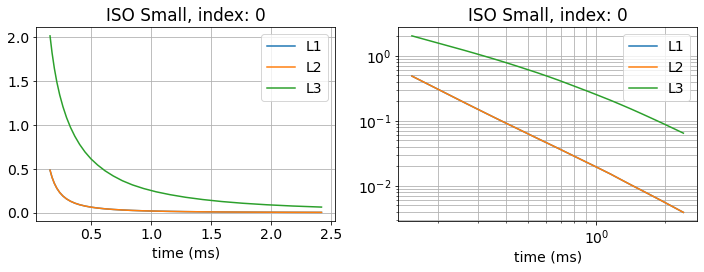

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
key = "ISO Small"
i = 0
for l in ["L1", "L2", "L3"]:
    L = ordnance[key][l][i]
    ax[0].plot(times, L, label=l)
    ax[1].loglog(times, L, label=l)

for a in ax:
    a.set_title(f"{key}, index: {i}")
    a.grid(which="both")
    a.legend()
    a.set_xlabel("time (ms)")
    # a.set_ylim([1e-3, 20])
        
plt.tight_layout()

In [6]:
fwd_params = uxo_utils.create_forward_modelling_params(
    sensorinfo, times, 
    survey_dict["mnum"], survey_dict["pos"], 
    survey_dict["pitch"], survey_dict["roll"], survey_dict["yaw"]
)

In [7]:
key = "ISO Small"
ind = 0
ord_loc = np.r_[0, 0, -0.1]
ord_ypr = np.r_[0, 0, 0]

L3, L2, L1 = (ordnance[key][l][ind] for l in ["L1", "L2", "L3"])

data_uxo = uxo_utils.simulate_object(
    L1, L2, L3, fwd_params, times, ord_loc, ord_ypr
)



In [8]:
mod = BTInvert.Model(xyz=ord_loc, gba=ord_ypr, l3=L3, l2=L2, l1=L1, times=times)

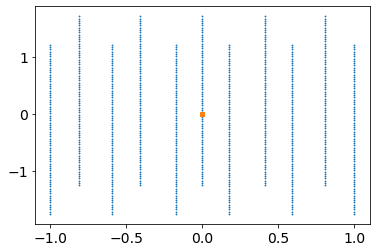

In [9]:
plt.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.', alpha=0.8, ms=1)
plt.plot(ord_loc[0], ord_loc[1], 's', ms=4)

In [10]:
sensor_table = sensorinfo.measNum2TxRxRxcCube()
# sensor_table = sensor_table[mnum, :]

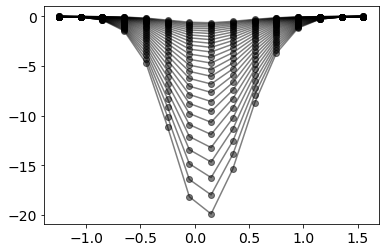

In [114]:
mnum_plot = 10
fig, ax = plt.subplots(1, 1)
ax.plot(
    survey_dict["pos"][survey_dict["mnum"] == mnum_plot, 1], 
    data_uxo[mnum_plot, :, :], "-ko", alpha=0.5
);

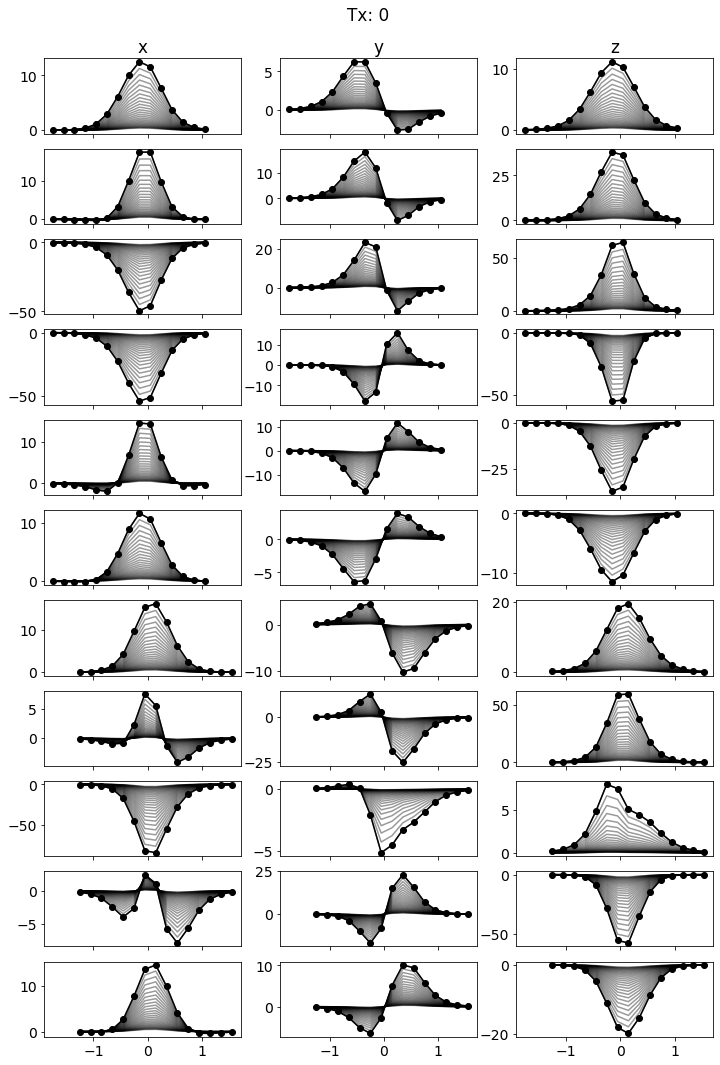

In [124]:
txind = 0  # transmitter
tind = 0  # time
fig, ax = plt.subplots(11, 3, figsize=(12, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (sensor_table[:, 0] == txind) & (sensor_table[:, 3]==i)
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        mnum_plot = np.where(rx_plot & (sensor_table[:, 2] == j))[0]
        y_plot = survey_dict["pos"][survey_dict["mnum"] == mnum_plot, 1]
        ax[i, j].plot(y_plot, data_uxo[mnum_plot, :, tind].squeeze(), "-o", color="k", label=mnum_plot)
        ax[i, j].plot(y_plot, data_uxo[mnum_plot, :, :].squeeze(), "-", color="k", alpha=0.4)
        # ax[i, j].legend()


In [13]:
# loop over transmitters
src_list = []
nrx = sensor_table[:, 3].max() + 1
ncomponents = sensor_table[:, 2].max() + 1
ndata = nrx*ncomponents

for i, txi in enumerate(survey_dict["txnum"]): 
    
    # reorder transmitter nodes so we are always doing right handed integrations
    tx = sensorinfo.transmitters[txi]
    tx_corners = np.vstack([tx.shape[i, :] for i in [2, 1, 0, 3, 2]])
    tx_corners = tx_corners + survey_dict["xyz"][i, :]

    receiver_inds = slice(i*ndata,i*ndata + nrx)

    receivers = pm.MagneticFluxDensityReceiver(
        survey_dict["pos"][receiver_inds, :], 
        components=["z", "y", "x"]
    )
    src = pm.MagneticControlledSource(receiver_list=[receivers], location=tx_corners, current=1)
    src_list.append(src)

In [14]:
survey = pm.Survey(src_list)
survey.nD

2475

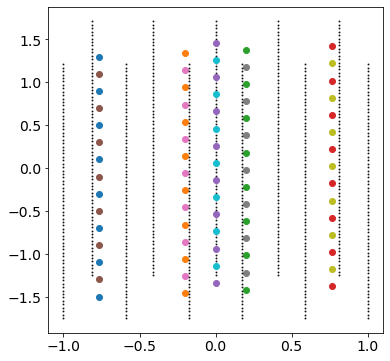

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# mesh.plot_grid(ax=ax, linewidth=1)

for src in survey.source_list: 
    rx_locs = src.receiver_list[0].locations
    ax.plot(
        (src.location[:, 0].min() + src.location[:, 0].max())/2.,
        (src.location[:, 1].min() + src.location[:, 1].max())/2.,
        "o"
    )
    ax.plot(rx_locs[:, 0], rx_locs[:, 1], '.k', alpha=0.8, ms=2)
    # ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

## set up mesh for inversion 

In [16]:
core_domain = 2 # meters
nc = 32
dx = core_domain/nc
npad = 4
pf = 1.5
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")
mesh.n_cells

1600

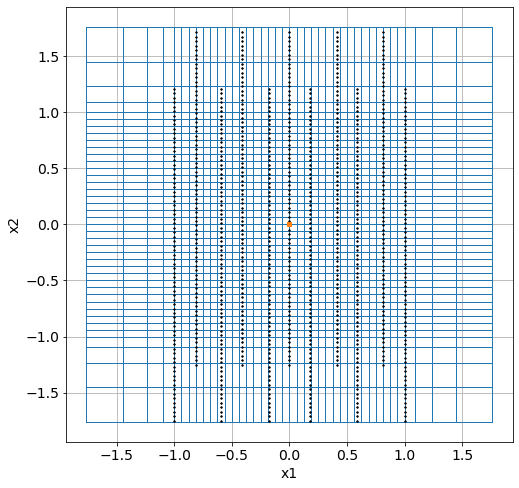

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

mesh.plot_grid(ax=ax, linewidth=1)
ax.plot(survey_dict["pos"][:, 0], survey_dict["pos"][:, 1], '.k', alpha=0.8, ms=2)
ax.plot(ord_loc[0], ord_loc[1], 's',color="C1", ms=4)

## create simulation for polarizabilities

In [18]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])
sim = pm.SimulationPolarizabilityModel(locations, survey)

Reorder the data / positions so that the receivers are ordered by location and then component. The default for Black Tusk is to order by component and then location. See the `sensor_table` and `sensor_table_reordered`. Both are 165 x 4 matrices with each column being 

```[transmitter_id, receiver_id, receiver_component, receiver_location_id]```

In [19]:
ntx = int(survey_dict["txnum"].max()) + 1

def reorder_mnum(sensor_table):
    return np.hstack([
        np.hstack([
                np.where(
                    (sensor_table[:, 3] == rxi) & 
                    (sensor_table[:, 0] == txi)
                )[0] for rxi in range(nrx)
        ]) for txi in range(ntx)
    ])

In [20]:
mnum_reordered = reorder_mnum(sensor_table)
sensor_table_reordered = sensor_table[mnum_reordered, :]

ncycles = int(len(survey_dict["mnum"])/len(mnum_reordered))
mnum_reordered_full = np.hstack([mnum_reordered]*ncycles)
sensor_table_reordered_full = sensor_table[mnum_reordered_full, :]

expanded_reorder = np.hstack([mnum_reordered + len(mnum_reordered)*i for i in range(ncycles)])

In [21]:
# sanity check that the reordering is correct
np.all(sensor_table_reordered_full == sensor_table[survey_dict["mnum"]][expanded_reorder, :])

True

In [22]:
pos_reordered = survey_dict["pos"][expanded_reorder, :]

## test example

test that we can simulate / invert for a polarizable block

In [23]:
mtest = np.zeros_like(locations)

x_target = np.r_[-0.125, 0.125]
y_target = np.r_[-0.125, 0.125]
m_target = np.r_[0.1, 0.1, 1]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtest[bounding_box, i] = m

mtest = mtest.flatten() #discretize.utils.mkvc(mtrue)

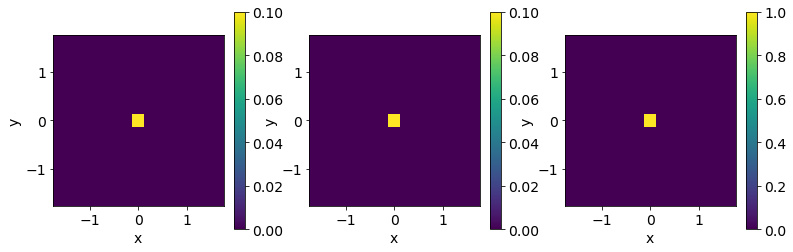

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mtest[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [25]:
dpred_test = sim.dpred(mtest)

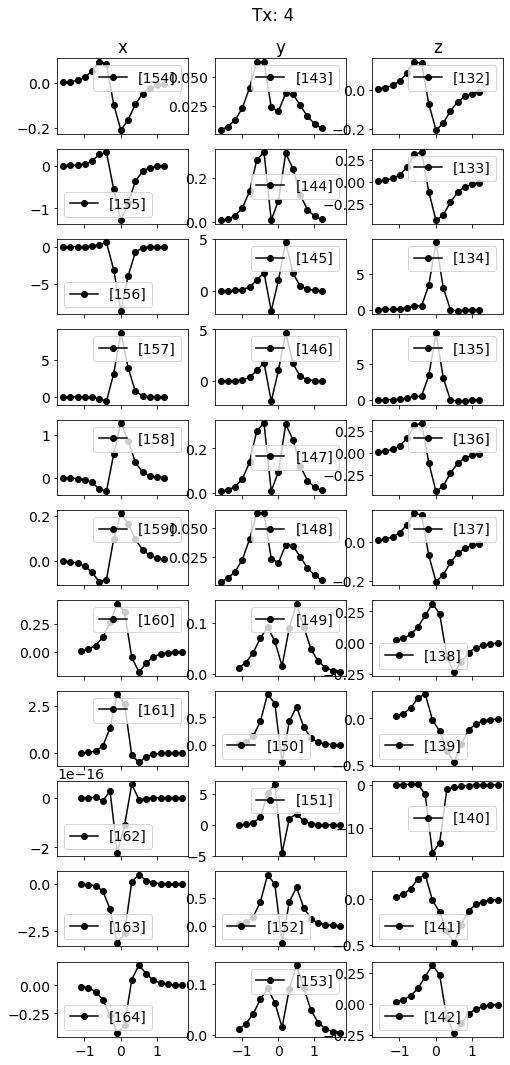

In [26]:
txind = 4 # transmitter
tind = 0  # time
fig, ax = plt.subplots(11, 3, figsize=(8, 18), sharex=True)

fig.suptitle(
    f"Tx: {txind}",
    y=0.92
)
for i in range(11):
    rx_plot = (
        (sensor_table_reordered_full[:, 0] == txind) & 
        (sensor_table_reordered_full[:, 3] == i)
    )
    for j, comp in enumerate(["x", "y", "z"]):
        if i == 0:
            ax[i, j].set_title(comp)
        inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

        y_plot = pos_reordered[inds_plot, 1]
        d_plot = dpred_test[inds_plot]
        ax[i, j].plot(y_plot, d_plot, "-o", color="k", label=np.unique(mnum_reordered_full[inds_plot]))
        ax[i, j].legend()


In [27]:
noise_floor = 0.05*np.max(np.abs(dpred_test))
inversion_test = pm.Inversion(sim, dpred_test, noise_floor, beta=None)

In [28]:
mrec_test = inversion_test.solve(beta_fact=1)

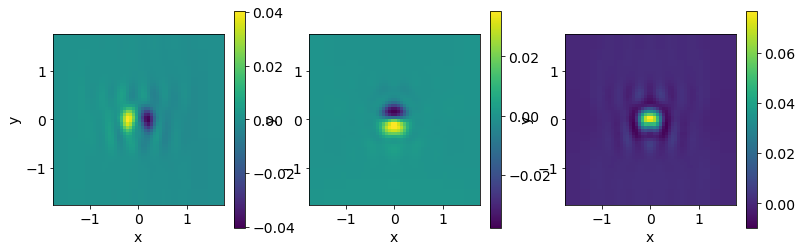

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [30]:
dpred_mrec_test = sim.dpred(mrec_test)
weighted_residual = inversion_test.Wd @ (dpred_mrec_test - dpred_test)
print(weighted_residual.dot(weighted_residual))

2042.6130474198549


### run inversion with positivity constraints

In [31]:
from SimPEG import (
    data_misfit, regularization, optimization, inverse_problem, 
    inversion, directives, Data
)

In [32]:
def setup_inversion(simulation, survey, dpred, noise_floor=None, beta0_ratio=None):
    if noise_floor is None: 
        noise_floor = 0.1*np.max(np.abs(dpred_test))
    if beta0_ratio is None:
        beta0_ratio = 1
        
    # data misfit 
    dmis = data_misfit.L2DataMisfit(
        data=Data(survey, dobs=dpred, noise_floor=noise_floor), 
        simulation=sim
    )

    # regularization -- only smallenss
    nmodel = mesh.nC*3
    map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
    map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
    map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
    reg = (
        regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(sim.locations)*3)) + 
        regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(sim.locations)*3)) + 
        regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(sim.locations)*3))  
    )
    
    # optimization and inverse problem
    opt = optimization.ProjectedGNCG(
        maxIterCG=60, stepOffBoundsFact=0, lower=0, maxIter=20
    ) 
    invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 
    
    directive_list = [
        directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio), 
        directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
        directives.TargetMisfit()
    ]
    
    inv = inversion.BaseInversion(invprob, directive_list)
    
    return inv

In [33]:
inv_test = setup_inversion(
    sim, survey, dpred_test, 
    noise_floor=0.01*np.max(np.abs(dpred_test)),
    beta0_ratio=2
)

In [34]:
mrec_test_pos = inv_test.run(np.zeros(mesh.nC * 3)+1e-8)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.43e+04  3.08e+04  2.40e-13  3.08e+04    2.28e+04      0              


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  1.21e+04  1.76e+04  2.28e-01  2.03e+04    8.18e+03      0              
   2  6.07e+03  1.19e+04  5.67e-01  1.53e+04    6.45e+03      0   Skip BFGS  
   3  3.04e+03  6.88e+03  1.15e+00  1.04e+04    4.58e+03      0   Skip BFGS  
   4  1.52e+03  3.53e+03  1.92e+00  6.45e+03    2.94e+03      0   Skip BFGS  
   5  7.59e+02  1.66e+03  2.78e+00  3.77e+03    1.71e+03      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.0756e+03
0 : |xc-x_last| = 4.2780e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7106e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7106e+03 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      6
------------------------- DONE! -------------------------


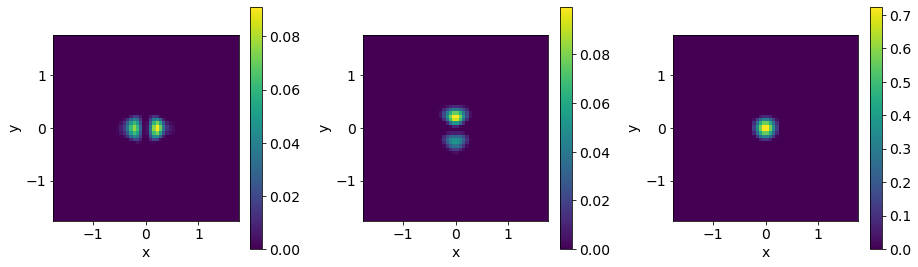

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec_test_pos[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)
plt.tight_layout()

In [36]:
dpred_mrec_test_pos = sim.dpred(mrec_test_pos)

In [37]:
def plot_observed_predicted(dobs, dpred, txind=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(11, 3, figsize=(12, 18), sharex=True)
    if fig is not None: 
        fig.suptitle(
            f"Tx: {txind}",
            y=0.92
        )
    for i in range(11):
        rx_plot = (
            (sensor_table_reordered_full[:, 0] == txind) & 
            (sensor_table_reordered_full[:, 3] == i)
        )
        for j, comp in enumerate(["x", "y", "z"]):
            if i == 0:
                ax[i, j].set_title(comp)
            inds_plot = np.where(rx_plot & (sensor_table_reordered_full[:, 2] == j))[0]

            y_plot = pos_reordered[inds_plot, 1]
            d_plot_obs = dobs[inds_plot]
            d_plot_pred = dpred[inds_plot]
            ax[i, j].plot(y_plot, d_plot_obs, "o", color="k", label="obs")
            ax[i, j].plot(y_plot, d_plot_pred, "-", color="C0", label="pred")
    
    ax[0, 0].legend()
    return ax

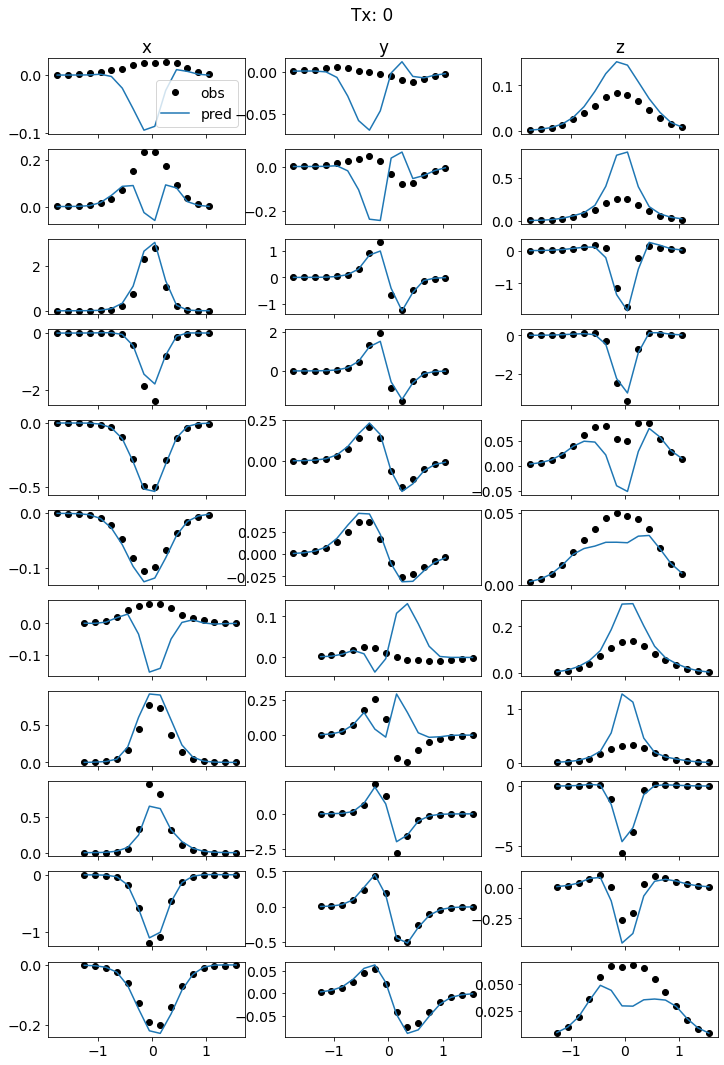

In [38]:
plot_observed_predicted(dpred_test, dpred_mrec_test_pos, txind=0);

## Now with UXO simulation 

In [87]:
def get_inversion_data_from_bt(data, time_invert, yaw=None): 
    data_uxo_rotated = data.copy()
    d_invert = data_uxo_rotated[:, :, time_invert]

    # find x, y indices, flip sign as Black tusk default integrates the other way
    mnum_xy = (sensor_table[:, 2] != 2)
    d_invert[mnum_xy, :] = d_invert[mnum_xy, :] * -1
    # NOTE: for multiple lines with different yaw, we will need to rotate data to consider that

    # flatten    
    d_invert = d_invert[mnum_reordered, :].flatten(order="F")
    
    return d_invert

In [137]:
d_invert = get_inversion_data_from_bt(data_uxo, time_invert=0)

In [138]:
sim = pm.SimulationPolarizabilityModel(
    locations, survey, mapping=maps.IdentityMap(nP=3*mesh.nC)
)

In [139]:
noise = 0.05*np.max(np.abs(d_invert)) 
inversion_uxo = pm.Inversion(sim, d_invert, noise, beta=None)

In [140]:
mrec0 = inversion_uxo.solve(beta_fact=1)

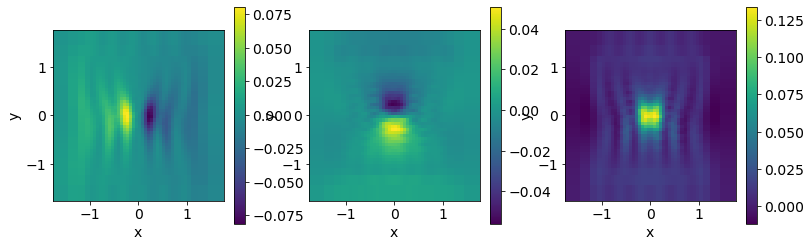

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec0[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)

In [142]:
survey.nD

2475

In [143]:
dpred_mrec0 = sim.dpred(mrec0)

## Now with simpeg

In [144]:
0.05*np.abs(d_invert).max()

5.836091811055834

In [145]:
inv = setup_inversion(
    sim, survey, d_invert, 
    noise_floor=0.05*np.max(np.abs(d_invert)),
    beta0_ratio=2
)

In [146]:
mrec = inv.run(np.zeros(mesh.nC * 3)+1e-8)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.57e+02  7.11e+03  2.40e-13  7.11e+03    1.05e+03      0              


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  1.28e+02  4.58e+03  4.05e+00  5.10e+03    3.65e+02      0              
   2  6.42e+01  3.56e+03  9.75e+00  4.19e+03    2.83e+02      0   Skip BFGS  
   3  3.21e+01  2.69e+03  1.94e+01  3.31e+03    2.00e+02      0   Skip BFGS  
   4  1.60e+01  2.05e+03  3.35e+01  2.59e+03    1.29e+02      0   Skip BFGS  
   5  8.02e+00  1.59e+03  5.41e+01  2.02e+03    7.74e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.1090e+02
0 : |xc-x_last| = 3.4874e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 7.7357e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.7357e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      6
------------------------- DONE! -------------------------


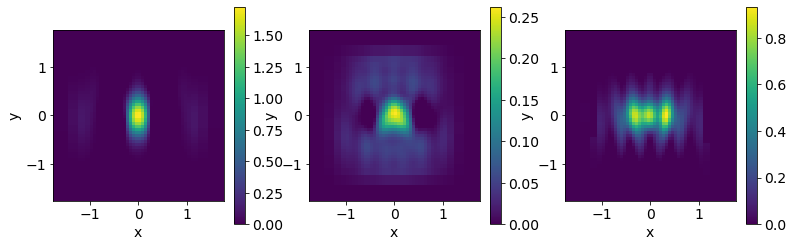

In [147]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec[i::3], ax=a)[0], ax=a)
    # a.set_xlim([-1, 1])
    # a.set_ylim([-1, 1])
    a.set_aspect(1)
    

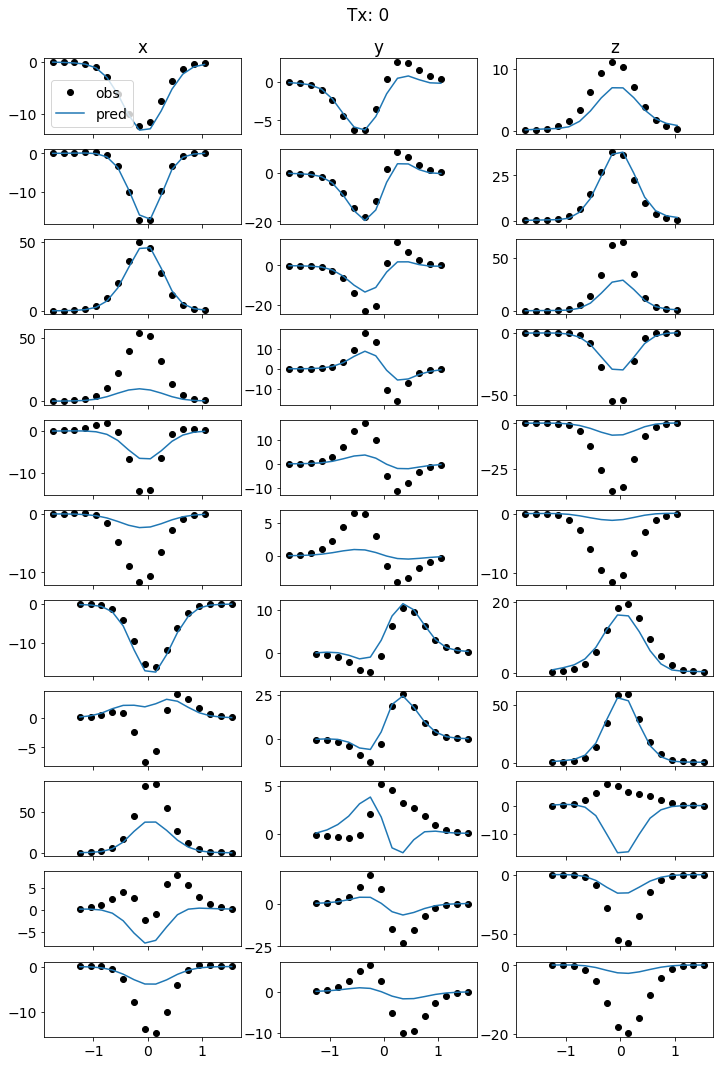

In [148]:
dpred_mrec = sim.dpred(mrec)
plot_observed_predicted(d_invert, dpred_mrec, txind=0);